In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, ClassLabel, DatasetDict
import numpy as np


import math
import time
from typing import Optional, Tuple, Dict

import torch.nn.functional as F
from tqdm import tqdm


In [2]:
dataset = load_dataset("Densu341/Fresh-rotten-fruit")

In [3]:
remove_labels = [18, 20, 16, 13, 2, 5, 7, 9]
labels = np.array(dataset["train"]["label"])
mask = ~np.isin(labels, remove_labels)

# 3. 필요 없는 라벨 제거
clean_dataset = dataset["train"].select(np.where(mask)[0])

# 4. train/val split
dataset = clean_dataset.train_test_split(test_size=0.2)
train_dataset, val_dataset = dataset["train"], dataset["test"]

# 5. 실제 남은 라벨 인덱스 및 이름 추출
unique_labels = sorted(set(train_dataset["label"]) | set(val_dataset["label"]))
all_labels = [train_dataset.features["label"].int2str(i) for i in unique_labels]

# 6. 새로운 ClassLabel 정의
new_classlabel = ClassLabel(num_classes=len(all_labels), names=all_labels)

# 7. 라벨 값 재매핑
def remap_labels(example):
    label_name = train_dataset.features["label"].int2str(example["label"])
    example["label"] = all_labels.index(label_name)
    return example

train_dataset = train_dataset.map(remap_labels)
val_dataset   = val_dataset.map(remap_labels)

train_dataset = train_dataset.cast_column("label", new_classlabel)
val_dataset   = val_dataset.cast_column("label", new_classlabel)

# 8. 최종 DatasetDict 생성
final_dataset = DatasetDict({
    "train": train_dataset,
    "test": val_dataset
})

Map:   0%|          | 0/21486 [00:00<?, ? examples/s]

Map:   0%|          | 0/5372 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/21486 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5372 [00:00<?, ? examples/s]

In [4]:
#테스트용
print("최종 라벨 목록:", final_dataset["train"].features["label"].names)



print("train 라벨 최소:", min(final_dataset["train"]["label"]))
print("train 라벨 최대:", max(final_dataset["train"]["label"]))
print("고유 라벨 집합:", sorted(set(final_dataset["train"]["label"])))

# 2. 라벨 이름과 매핑 확인
print("라벨 이름 목록:", final_dataset["train"].features["label"].names)

# 3. 샘플 몇 개 찍어보기
for i in range(5):
    label_id = final_dataset["train"][i]["label"]
    label_name = final_dataset["train"].features["label"].int2str(label_id)
    print(f"샘플 {i}: 라벨ID={label_id}, 라벨이름={label_name}")

최종 라벨 목록: ['freshapples', 'freshbanana', 'freshcapsicum', 'freshcucumber', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencapsicum', 'rottencucumber', 'rottenoranges', 'rottenpotato', 'rottentomato']
train 라벨 최소: 0
train 라벨 최대: 13
고유 라벨 집합: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
라벨 이름 목록: ['freshapples', 'freshbanana', 'freshcapsicum', 'freshcucumber', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencapsicum', 'rottencucumber', 'rottenoranges', 'rottenpotato', 'rottentomato']
샘플 0: 라벨ID=8, 라벨이름=rottenbanana
샘플 1: 라벨ID=7, 라벨이름=rottenapples
샘플 2: 라벨ID=0, 라벨이름=freshapples
샘플 3: 라벨ID=0, 라벨이름=freshapples
샘플 4: 라벨ID=8, 라벨이름=rottenbanana


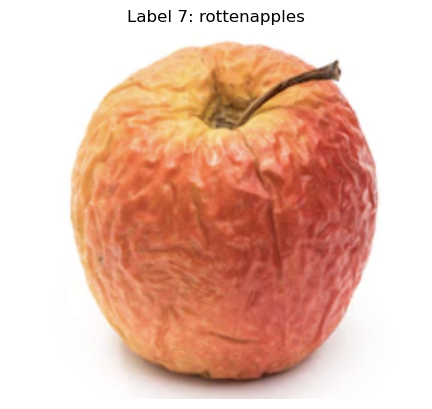

In [ ]:
# 시각화 테스트
import matplotlib.pyplot as plt

target_label = 7  # 확인하고 싶은 라벨 인덱스

# 해당 라벨의 샘플 하나 찾기
for sample in train_dataset:
    if sample["label"] == target_label:
        image = sample["image"]
        break

# 라벨 인덱스 → 라벨 이름 변환
label_name = train_dataset.features["label"].int2str(target_label)

# 시각화
plt.imshow(image)
plt.title(f"Label {target_label}: {label_name}")
plt.axis("off")
plt.show()

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])  # ImageNet 기준
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# --------------------------------------------------
# PyTorch Dataset 래퍼
# --------------------------------------------------
class FruitHFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"].convert("RGB")  # RGBA → RGB
        label = sample["label"]                # 이미 0~N-1 정수
        if self.transform:
            image = self.transform(image)
        return image, label

# --------------------------------------------------
# DataLoader 생성
# --------------------------------------------------
train_loader = DataLoader(
    FruitHFDataset(final_dataset["train"], transform=train_transform),
    batch_size=32, shuffle=True, drop_last=True
)
val_loader = DataLoader(
    FruitHFDataset(final_dataset["test"], transform=val_transform),
    batch_size=32, shuffle=False
)

num_classes = len(final_dataset["train"].features["label"].names)

In [8]:
# 배치 하나만 꺼내서 확인
images, labels = next(iter(train_loader))

print("이미지 텐서 shape:", images.shape)      # (batch, channel, height, width)
print("이미지 텐서 dtype:", images.dtype)      # torch.float32 기대
print("이미지 값 범위:", images.min().item(), " ~ ", images.max().item())  # 정규화 확인
print("라벨 텐서 shape:", labels.shape)        
print("라벨 dtype:", labels.dtype)             # torch.int64 (long) 기대
print("라벨 예시:", labels[:10].tolist()) 

이미지 텐서 shape: torch.Size([32, 3, 224, 224])
이미지 텐서 dtype: torch.float32
이미지 값 범위: -2.1179039478302  ~  2.640000104904175
라벨 텐서 shape: torch.Size([32])
라벨 dtype: torch.int64
라벨 예시: [4, 10, 0, 1, 7, 2, 7, 8, 13, 7]


In [5]:
# 1. 고유 라벨 추출
unique_labels = sorted(set(final_dataset["train"]["label"]) | set(final_dataset["test"]["label"]))
print("실제 라벨 인덱스:", unique_labels)

# 2. 재매핑 딕셔너리 생성
label2idx = {old: new for new, old in enumerate(unique_labels)}
print("라벨 매핑:", label2idx)

# 3. 매핑 함수
def remap(example):
    example["label"] = label2idx[example["label"]]
    return example

# 4. 라벨 다시 매핑
final_dataset = final_dataset.map(remap)

# 5. 클래스 개수 확인
num_classes = len(unique_labels)
print("최종 클래스 개수:", num_classes)


실제 라벨 인덱스: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
라벨 매핑: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13}


Map:   0%|          | 0/21486 [00:00<?, ? examples/s]

Map:   0%|          | 0/5372 [00:00<?, ? examples/s]

최종 클래스 개수: 14


In [14]:

# =========================
# Config 클래스
# =========================
class Cfg:
    IMAGE_SIZE = 224  # (H,W) 전처리에서 Resize((224,224)) 가정
    PATCH_DOWN = 16   # CNN으로 1/16 해상도까지 다운샘플 (224->14)
    D_MODEL = 384     # Transformer 임베딩 차원
    N_HEAD = 6
    DEPTH  = 6
    MLP_RATIO = 4
    DROPOUT = 0.1
    ATTN_DROPOUT = 0.1

    # 학습 관련
    LR = 3e-4
    EPOCHS = 10
    BATCH_SIZE = 64
    NUM_WORKERS = 0 #4
    MIXED_PRECISION = True

    # 태스크 토글
    MULTITASK = False  # True: (과일종, 신선도) 두 개의 헤드
    NUM_CLASSES = 14   # 단일 과제일 때 클래스 수

    # 멀티태스크일 때 각 헤드 클래스 수
    NUM_FRUIT = 7
    NUM_FRESH = 2


# =========================
# 작은 CNN Stem
#  - 출력: (B, C, H', W') with H'=W'=IMAGE_SIZE/PATCH_DOWN
# =========================
class CNNStem(nn.Module):
    def __init__(self, in_ch=3, out_ch=Cfg.D_MODEL):
        super().__init__()
        # 224 -> 112 -> 56 -> 28 -> 14  (총 stride 16)
        def block(cin, cout, stride):
            return nn.Sequential(
                nn.Conv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.Conv2d(cout, cout, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
            )
        self.stem = nn.Sequential(
            block(in_ch,   96,  stride=2),  # 224 -> 112
            block(96,     192,  stride=2),  # 112 -> 56
            block(192,    256,  stride=2),  # 56  -> 28
            block(256,    out_ch, stride=2) # 28  -> 14
        )
        # 1x1 conv로 채널 정렬해도 되지만 위에서 out_ch로 맞춤

    def forward(self, x):
        return self.stem(x)  # (B, D_MODEL, 14, 14)


# =========================
# Positional Embedding + CLS 토큰
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, num_patches_plus_cls):
        super().__init__()
        self.pos = nn.Parameter(torch.zeros(1, num_patches_plus_cls, d_model))
        nn.init.trunc_normal_(self.pos, std=0.02)

    def forward(self, x):
        # x: (B, N, C)
        return x + self.pos


# =========================
# Transformer Encoder
# =========================
def make_encoder(d_model, nhead, depth, mlp_ratio, dropout, attn_dropout):
    layers = []
    for _ in range(depth):
        layers.append(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=int(d_model * mlp_ratio),
                dropout=dropout,
                activation="gelu",
                batch_first=True,
                norm_first=True
            )
        )
    return nn.TransformerEncoder(nn.Sequential(*layers), num_layers=depth)


# =========================
# 전체 모델
# =========================
class CNNTransformer(nn.Module):
    def __init__(self,
                 num_classes: Optional[int] = None,
                 multitask: bool = False,
                 num_fruit: int = 7,
                 num_fresh: int = 2):
        super().__init__()
        self.multitask = multitask

        self.cnn = CNNStem(in_ch=3, out_ch=Cfg.D_MODEL)

        # 토큰화: (B, C, H, W) -> (B, N, C)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, Cfg.D_MODEL))
        h = w = Cfg.IMAGE_SIZE // Cfg.PATCH_DOWN    # 14
        self.num_patches = h * w
        self.pos = PositionalEncoding(Cfg.D_MODEL, self.num_patches + 1)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=Cfg.D_MODEL,
                nhead=Cfg.N_HEAD,
                dim_feedforward=int(Cfg.D_MODEL * Cfg.MLP_RATIO),
                dropout=Cfg.DROPOUT,
                activation="gelu",
                batch_first=True,
                norm_first=True
            ),
            num_layers=Cfg.DEPTH
        )

        # Heads
        if multitask:
            self.head_fruit = nn.Linear(Cfg.D_MODEL, num_fruit)
            self.head_fresh = nn.Linear(Cfg.D_MODEL, num_fresh)
        else:
            assert num_classes is not None, "num_classes 를 지정하세요 (단일 과제 모드)."
            self.head = nn.Linear(Cfg.D_MODEL, num_classes)

        # 초기화
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # CNN feature
        feat = self.cnn(x)                 # (B, C, 14, 14)
        B, C, H, W = feat.shape
        tokens = feat.flatten(2).permute(0, 2, 1)  # (B, N=H*W, C)

        # prepend CLS
        cls = self.cls_token.expand(B, -1, -1)    # (B, 1, C)
        x = torch.cat([cls, tokens], dim=1)       # (B, 1+N, C)
        x = self.pos(x)

        # Transformer
        x = self.encoder(x)                       # (B, 1+N, C)
        cls_out = x[:, 0]                         # (B, C)

        if self.multitask:
            return self.head_fruit(cls_out), self.head_fresh(cls_out)
        else:
            return self.head(cls_out), None


# =========================
# Loss helpers
# =========================
def loss_single(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return F.cross_entropy(logits, targets)

def loss_multi(
    logits_fruit: torch.Tensor, targets_fruit: torch.Tensor,
    logits_fresh: torch.Tensor, targets_fresh: torch.Tensor,
    alpha: float = 1.0, beta: float = 1.0
) -> torch.Tensor:
    lf = F.cross_entropy(logits_fruit, targets_fruit)
    ls = F.cross_entropy(logits_fresh, targets_fresh)
    return alpha * lf + beta * ls

# =========================


def _get_logits(outputs):
    return outputs[0] if isinstance(outputs, (tuple, list)) else outputs


def train_loop(model: nn.Module,
               train_loader: torch.utils.data.DataLoader,
               val_loader: Optional[torch.utils.data.DataLoader],
               optimizer: torch.optim.Optimizer,
               epochs: int,
               device: torch.device,
               multitask: bool = False,
               scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
               grad_clip: Optional[float] = None):
    """
    깔끔 학습 루프:
      - AMP 지원
      - 단일/멀티태스크 지원
      - 검증: loss/acc 둘 다 반환/출력
      - 선택: grad clip, 스케줄러
    """
    ce = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=getattr(Cfg, "MIXED_PRECISION", True))

    for epoch in range(1, epochs + 1):
        model.train()
        t0 = time.time()
        running_loss = 0.0
        running_correct, running_total = 0, 0

        loop = tqdm(train_loader, desc=f"[Train] {epoch}/{epochs}", leave=True)
        for batch in loop:
            optimizer.zero_grad(set_to_none=True)

            if multitask:
                images, (y_fruit, y_fresh) = batch
                images   = images.to(device, non_blocking=True)
                y_fruit  = y_fruit.to(device, non_blocking=True).long()
                y_fresh  = y_fresh.to(device, non_blocking=True).long()

                with torch.cuda.amp.autocast(enabled=getattr(Cfg, "MIXED_PRECISION", True)):
                    logits_fruit, logits_fresh = model(images)
                    loss = ce(logits_fruit, y_fruit) + ce(logits_fresh, y_fresh)

                # acc는 관례적으로 과일 헤드 기준
                preds = logits_fruit.argmax(dim=1)
                running_correct += (preds == y_fruit).sum().item()
                running_total   += y_fruit.size(0)

            else:
                images, y = batch
                images = images.to(device, non_blocking=True)
                y      = y.to(device, non_blocking=True).long()

                with torch.cuda.amp.autocast(enabled=getattr(Cfg, "MIXED_PRECISION", True)):
                    outputs = model(images)
                    logits  = _get_logits(outputs)     # tuple 안전 처리
                    loss    = ce(logits, y)

                preds = logits.argmax(dim=1)
                running_correct += (preds == y).sum().item()
                running_total   += y.size(0)

            # backward + step
            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

            running_loss += float(loss.detach().cpu())

            # 진행 표시
            loop.set_postfix(loss=f"{loss.item():.4f}",
                             lr=f"{optimizer.param_groups[0]['lr']:.2e}")

        # 스케줄러 스텝 (에폭단위)
        if scheduler is not None:
            scheduler.step()

        train_loss = running_loss / max(1, len(train_loader))
        train_acc  = running_correct / max(1, running_total)
        epoch_time = time.time() - t0
        print(f"Epoch {epoch}: train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | time={epoch_time:.1f}s")

        # ---- Validation ----
        if val_loader is not None:
            val_stats = evaluate(model, val_loader, device, multitask)
            print(f"           val_loss={val_stats['val_loss']:.4f} | val_acc={val_stats['val_acc']:.4f}")


@torch.no_grad()
def evaluate(model: nn.Module,
             loader: torch.utils.data.DataLoader,
             device: torch.device,
             multitask: bool = False) -> Dict[str, float]:
    model.eval()
    ce = nn.CrossEntropyLoss()
    total, correct = 0, 0
    total_loss = 0.0

    if multitask:
        # 멀티태스크: 과일/신선도 모두 CE 합산, acc는 과일 헤드 기준
        for images, (y_fruit, y_fresh) in loader:
            images = images.to(device, non_blocking=True)
            y_fruit = y_fruit.to(device, non_blocking=True).long()
            y_fresh = y_fresh.to(device, non_blocking=True).long()

            logits_fruit, logits_fresh = model(images)
            loss = ce(logits_fruit, y_fruit) + ce(logits_fresh, y_fresh)
            total_loss += float(loss.detach().cpu())

            preds = logits_fruit.argmax(dim=1)
            correct += (preds == y_fruit).sum().item()
            total   += y_fruit.size(0)
        return {"val_loss": total_loss / max(1, len(loader)),
                "val_acc":  correct / max(1, total)}
    else:
        for images, y in loader:
            images = images.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()

            outputs = model(images)
            logits  = _get_logits(outputs)
            loss    = ce(logits, y)
            total_loss += float(loss.detach().cpu())

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
        return {"val_loss": total_loss / max(1, len(loader)),
                "val_acc":  correct / max(1, total)}

    

In [11]:
#gpu에서 돌아가는지 확인 하는 코드 "cuda"로 나오면 정상

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
next(model.parameters()).device

cuda


device(type='cuda', index=0)

In [12]:


class CNNTransformerPatch(nn.Module):
    def __init__(self, num_classes=10, embed_dim=256, num_heads=4, num_layers=2):
        super(CNNTransformerPatch, self).__init__()
        
        # -------------------
        # 1. CNN Backbone (ResNet18 from HuggingFace weights)
        # -------------------
        self.cnn = models.resnet18(pretrained=False)
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()  # FC 제거, feature map 추출 용도
        
        # -------------------
        # 2. Transformer Encoder
        # -------------------
        self.embedding = nn.Linear(in_features, embed_dim)  
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # -------------------
        # 3. Classifier
        # -------------------
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # CNN Feature Map (예: [B, 512, 7, 7])
        x = self.cnn.conv1(x)
        x = self.cnn.bn1(x)
        x = self.cnn.relu(x)
        x = self.cnn.maxpool(x)

        x = self.cnn.layer1(x)
        x = self.cnn.layer2(x)
        x = self.cnn.layer3(x)
        x = self.cnn.layer4(x)          # [B, 512, H, W]

        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)       # [B, H, W, C]
        x = x.reshape(B, H*W, C)        # [B, N, C], N=H*W (토큰 개수)
        
        # 임베딩
        x = self.embedding(x)           # [B, N, embed_dim]
        
        # Transformer
        x = self.transformer(x)         # [B, N, embed_dim]
        x = x.mean(dim=1)               # [B, embed_dim] (토큰 평균 풀링)
        
        # Classifier
        out = self.fc(x)                # [B, num_classes]
        return out


In [15]:
#from cnn_transformer import CNNTransformer, Cfg, train_loop
#from torch.utils.data import DataLoader
#import torch 
#.py파일로 짤때

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = CNNTransformer(
    num_classes=Cfg.NUM_CLASSES,
    multitask=Cfg.MULTITASK,
    num_fruit=Cfg.NUM_FRUIT,
    num_fresh=Cfg.NUM_FRESH
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=Cfg.LR)


train_loader = DataLoader(
    FruitHFDataset(final_dataset["train"], transform=train_transform),
    batch_size=Cfg.BATCH_SIZE, shuffle=True, num_workers=Cfg.NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    FruitHFDataset(final_dataset["test"], transform=val_transform),
    batch_size=Cfg.BATCH_SIZE, shuffle=False, num_workers=Cfg.NUM_WORKERS, pin_memory=True
)

train_loop(model, train_loader, val_loader, optimizer,
           epochs=Cfg.EPOCHS, device=device,
           multitask=Cfg.MULTITASK)

torch.save(model.state_dict(), "fruit_model.pth")
#훈련하고 나온 가중치 저장



Device: cuda


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_7968\3754272798.py:202: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=getattr(Cfg, "MIXED_PRECISION", True))
[Train] 1/10:   0%|          | 0/336 [00:00<?, ?it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_7968\3754272798.py:234: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=getattr(Cfg, "MIXED_PRECISION", True)):
[Train] 1/10:   0%|          | 1/336 [00:44<4:08:54, 44.58s/it, loss=2.6237, lr=3.00e-04]


KeyboardInterrupt: 

In [ ]:
fruit_names = ["사과", "바나나", "토마토", "배", "포도"]  # 추후 수정
fresh_status = ["신선", "상함"]

def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # [1, C, H, W]
        outputs = model(image)
        pred = torch.argmax(outputs, dim=1).item()

        fruit_idx = pred // 2
        status_idx = pred % 2
        return f"{fruit_names[fruit_idx]} - {fresh_status[status_idx]}"